In [1]:
# Setup and imports
%load_ext autoreload
%autoreload 2

from battleship.board import Board
from battleship.agents import Question, EIGCalculator
from battleship.game import BattleshipGame
from battleship.captains import create_captain
from battleship.spotters import create_spotter
from battleship.fast_sampler import FastSampler

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import logging

# enable debug globally but silence DEBUG logs from battleship.fast_sampler
logging.basicConfig(level=logging.DEBUG)
logging.getLogger("battleship.fast_sampler").setLevel(logging.INFO)

In [26]:
BOARD_ID = "B03"
SEED = 123

true_board = Board.from_trial_id(BOARD_ID)
true_board

spotter = create_spotter(
    spotter_type="CodeSpotterModel",
    board_id=BOARD_ID,
    board_experiment="collaborative",
    llm="gpt-5",
    use_cot=True,
    json_path=None,
 )

captain = create_captain(
    captain_type="RationalDecisionCaptain_cot",
    seed=SEED,
    # llm="gpt-5",
    llm="gpt-4o",
    board_id=BOARD_ID,
    map_samples=1000,
    eig_samples=1000,
    eig_k=2,
    json_path=None,
 )

game = BattleshipGame(
    board_target=true_board,
    captain=captain,
    spotter=spotter,
)

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'idempotency_key': 'stainless-python-retry-2bdb4b0f-ecb6-4d48-b0a2-883b6693dc95', 'json_data': {'messages': [{'role': 'system', 'content': "You are playing the board game Battleship. In this variant of the game, pairs of players collaborate as a team to find the location of ships on the board. Each player is assigned to one of two roles: the 'Captain' or the 'Spotter'. The Captain's role is to decide when and where to reveal tiles on the board. On each turn, the Captain can ask the Spotter a question about the board, or make a move by guessing a tile that they think contains a ship. The Spotter's role is to provide the Captain with information about the hidden tiles. The Spotter has full visibility of the board, but can only answer the Captain's questions with 'Yes' or 'No'.\nThe board is an 8x8 grid, with lettered rows A, B, C, D, E, F, G, H and numbered columns 1, 2, 3, 4, 5, 6, 7

Planner best question: Question(text='Is there any part of a ship located in row D, columns 3 to 6 inclusive?')
p_hit_before (planner): 0.3080
p_hit_after  (planner): 0.4270


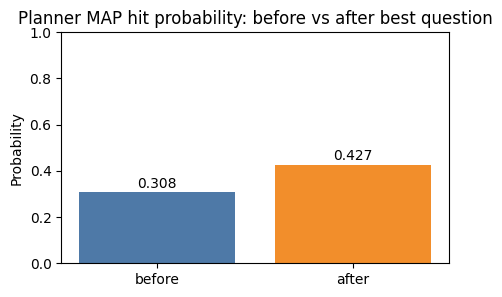

In [27]:
# Use the captain's StrategyPlanner plan to plot p_hit_before vs p_hit_after
planner = captain.decision_strategy.planner
ship_tracker = game.get_reordered_ship_tracker(game.state)
plan = planner.plan_turn(
    state=game.state,
    history=game.history,
    questions_remaining=game.max_questions - game.question_count,
    moves_remaining=game.max_moves - game.move_count,
    ship_tracker=ship_tracker,
 )

p_before = plan.p_hit_before
p_after = plan.p_hit_after if plan.p_hit_after is not None else plan.p_hit_before
print(f"Planner best question: {plan.best_question}")
print(f"p_hit_before (planner): {p_before:.4f}")
print(f"p_hit_after  (planner): {p_after:.4f}")

# Matplotlib bar chart
labels = ["before", "after"]
values = [p_before, p_after]
plt.figure(figsize=(5, 3))
plt.bar(labels, values, color=["#4e79a7", "#f28e2b"])
plt.title("Planner MAP hit probability: before vs after best question")
plt.ylabel("Probability")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha="center")
plt.show()

In [43]:
[(x["question"]["question"]["text"], x["eig"]) for x in plan.eig_candidates]

[('Is there any part of a ship located in row D, columns 3 to 6 inclusive?',
  0.5028832498967764),
 ('Is there any part of a ship located in rows A, B, C, or D?',
  0.01503353926097517)]

In [44]:
plan

Plan(best_move=(3, 4), p_hit_before=0.308, best_question=Question(text='Is there any part of a ship located in row D, columns 3 to 6 inclusive?'), best_code_question=<battleship.agents.CodeQuestion object at 0x16c6bee10>, best_eig=0.5028832498967764, eig_candidates=[{'stage_index': None, 'action': 'question', 'prompt': "[system]You are playing the board game Battleship. In this variant of the game, pairs of players collaborate as a team to find the location of ships on the board. Each player is assigned to one of two roles: the 'Captain' or the 'Spotter'. The Captain's role is to decide when and where to reveal tiles on the board. On each turn, the Captain can ask the Spotter a question about the board, or make a move by guessing a tile that they think contains a ship. The Spotter's role is to provide the Captain with information about the hidden tiles. The Spotter has full visibility of the board, but can only answer the Captain's questions with 'Yes' or 'No'.\nThe board is an 8x8 gri

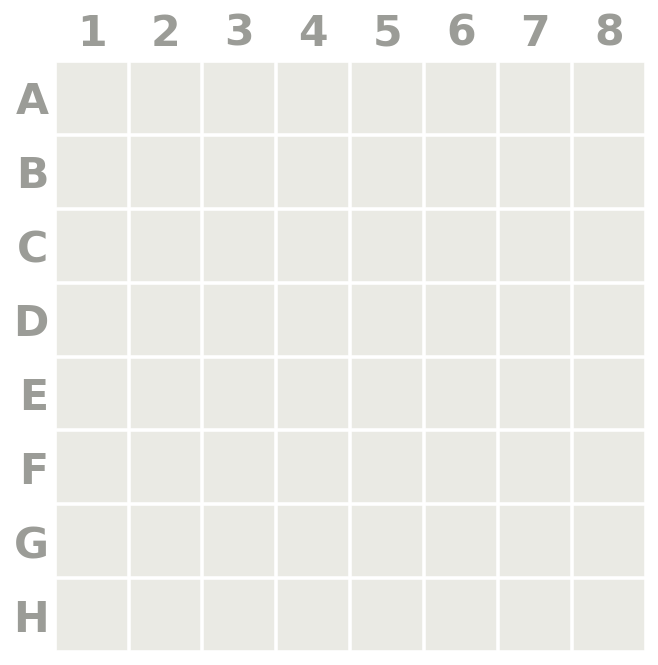

In [29]:
game.state

In [30]:
# Evaluate an arbitrary question using planner helper (no duplication)
nl_question = Question("Is the green ship vertical?")
code_question = spotter.translate(question=nl_question, board=game.state, history=game.history)
p_after_custom, t_info, f_info = planner.expected_post_question_hit_prob(
    state=game.state, code_question=code_question, constraints=captain.sampling_constraints
)
print("Custom question:", nl_question.text)
print("Expected p_hit_after:", f"{p_after_custom:.4f}")
print("True partition:", t_info)
print("False partition:", f_info)

DEBUG:root:[system]You are playing the board game Battleship. In this variant of the game, pairs of players collaborate as a team to find the location of ships on the board. Each player is assigned to one of two roles: the 'Captain' or the 'Spotter'. The Captain's role is to decide when and where to reveal tiles on the board. On each turn, the Captain can ask the Spotter a question about the board, or make a move by guessing a tile that they think contains a ship. The Spotter's role is to provide the Captain with information about the hidden tiles. The Spotter has full visibility of the board, but can only answer the Captain's questions with 'Yes' or 'No'.
The board is an 8x8 grid, with lettered rows A, B, C, D, E, F, G, H and numbered columns 1, 2, 3, 4, 5, 6, 7, 8. Coordinates are specified as a row, column pair. For example, C2 is the tile in row C, column 2.
There are four ships on the board: Green, Red, Purple, and Orange. Ships are oriented either horizontally or vertically and r

Custom question: Is the green ship vertical?
Expected p_hit_after: 0.2900
True partition: {'move': (4, 3), 'prob': 0.2978303747534517, 'weight': 0.5070000000000003}
False partition: {'move': (3, 3), 'prob': 0.281947261663286, 'weight': 0.4930000000000004}


In [31]:
plan.p_hit_after

0.427